# Draft `pyGIMLi(emg3d)` - Inversion

**An attempt at using `pyGIMLi` as an inversion framework for `emg3d` computations.**

=> Create an environment using the provided `environment.yml`: `mamba env create`.

For developing purposes, we take a very simple model and survey:
- Simple double-halfspace model water-subsurface with a resistive block.
- Survey: A single 2D line, 7 sources, 7 frequencies.

**Current Limitations**
- Only isotropic models supported
- Only 'Conductivity' models supported
- Without el. perm. and magn. perm.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm

import emg3d
import pygimli as pg
from pygimli.frameworks.lsqrinversion import LSQRInversion

## Load survey (incl. data), initial model, and create a Simulation

In [2]:
inp_data = emg3d.load('pginv.h5')        # Finer model (but still coarse)

inp_survey = inp_data['survey']
inp_model = inp_data['model']
inp_grid = inp_model.grid
inp_model

Data loaded from «/palmyra/data/dieterwerthmul/dev-pygimli-emg3d/pginv.h5»
[emg3d v1.8.2 (format 1.0) on 2023-12-16T18:16:42.291994].


Model: resistivity; isotropic; 142 x 62 x 24 (211,296)

In [3]:
# The model is resistivity. Change it to conductivity
# TODO: make this internally happen, so that pyGIMLi
# always gets a conductivity model!
con_model = emg3d.Model(inp_grid, 1/inp_model.property_x, mapping='Conductivity')
con_model

Model: conductivity; isotropic; 142 x 62 x 24 (211,296)

In [4]:
# For dev-purposes, we only select one source
# [for dev-purposes it is also a very simple model]
#inp_survey = inp_survey.select(sources='TxED-1')
inp_survey

:: Survey ::

<xarray.Dataset>
Dimensions:   (src: 7, rec: 57, freq: 7)
Coordinates:
  * src       (src) <U6 'TxED-1' 'TxED-2' 'TxED-3' ... 'TxED-6' 'TxED-7'
  * rec       (rec) <U7 'RxEP-01' 'RxEP-02' 'RxEP-03' ... 'RxEP-56' 'RxEP-57'
  * freq      (freq) <U3 'f-1' 'f-2' 'f-3' 'f-4' 'f-5' 'f-6' 'f-7'
Data variables:
    observed  (src, rec, freq) complex128 (5.665383933859002e-08-2.7490250101...
Attributes:
    noise_floor:     1e-15
    relative_error:  0.03

## Create a Starting Model

In [71]:
hx = np.ones(58)*250.0
hy = np.ones(26)*250.0
hz = np.ones(15)*250.0
grid = emg3d.TensorMesh([hx, hy, hz], [-7250, -3250, -3500])

model = emg3d.Model(grid, 1.0, mapping='Conductivity')
model.property_x[:, :, -1:] = 3.33

# QC
grid

TensorMesh: 22,620 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     58     -7,250.00      7,250.00    250.00    250.00    1.00
   y     26     -3,250.00      3,250.00    250.00    250.00    1.00
   z     15     -3,500.00        250.00    250.00    250.00    1.00

## Create a Simulation

In [6]:
# Create an emg3d Simulation instance
sim = emg3d.simulations.Simulation(
    survey=inp_survey,
    model=model,
    gridding='both', #'same',  # I would like to make that more flexible in the future
    gridding_opts={'vector': 'xyz'},
    max_workers=50,    # Adjust as needed
    receiver_interpolation='linear',  # Currently necessary for the gradient
    #solver_opts={'plain': True, 'maxit': 1},  # Just for dev-purpose
    #solver_opts={'tol': 1e-4},                # Just for dev-purpose
    tqdm_opts=False,  # Switch off verbose progress bars
)
sim

## Jacobian Wrapper (should move to a py-file)

In [7]:
class JacobianXemg3d(pg.Matrix):
    """Create a Jacobian operator to use emg3d as kernel within pyGIMLi."""
    
    def __init__(self, sim):
        super().__init__()
        self.sim = sim

    def cols(self):
        # sim.model.size corresponds to the number of cells
        return self.sim.model.size

    def rows(self):
        # sim.survey.count corresponds to the number of non-NaN data points.
        # Multiply by 2 for real + imaginary parts.
        return self.sim.survey.count * 2

    def mult(self, x):
        """J * x """
        # - Input x has size of the model; later, we want to generalize that
        #   to allow for anisotropic models etc.
        # - Output has size of non-NaN data [Re, Im]
        jvec = self.sim.jvec(np.reshape(x, self.sim.model.shape, order='F'))
        data = jvec[self.sim._finite_data]
        return np.hstack((data.real, data.imag))

    def transMult(self, x):
        """J.T * x = (x * J.T)^T """
        # - Input has size of non-NaN data [Re, Im]
        # - Output has size of the model
        data = np.ones(self.sim.survey.shape, dtype=self.sim.data.observed.dtype)*np.nan
        x = np.asarray(x)
        data[self.sim._finite_data] = x[:x.size//2] + 1j*x[x.size//2:]
        return self.sim.jtvec(data).ravel('F')
    
    def save(self, *args):
        pass

## Forward Wrapper (should move to a py-file)

In [8]:
class KernelXemg3d(pg.Modelling):
    """Create a forward operator to use emg3d as kernel within pyGIMLi."""
    
    def __init__(self, sim):
        """Initialize the pyGIMLi(emg3d)-wrapper."""
        
        # Initiate first pg.Modelling, which will do its magic.
        super().__init__()
        
        # Check current limitations; PURELY for development
        # IMPROVE (implement fully or convert to checks, do not do assert!)
        assert sim.model.case == 'isotropic'
        assert sim.model.map.name == 'Conductivity'
        
        # Add a bool to the simulation which selects all data
        # which are finite (this should go into emg3d.survey directly!)
        sim._finite_data = np.isfinite(sim.data.observed.data)
        
        # Store the simulation
        self.sim = sim
        
        # Translate discretize TensorMesh to pg-Grid
        self.mesh_ = pg.createGrid(
            x=sim.model.grid.nodes_x,
            y=sim.model.grid.nodes_y,
            z=sim.model.grid.nodes_z,
        )
        
        # Set marker -> water is 1, subsurface is 0
        # JUST TO DEVELOP, this SHOULD NOT be hard-coded in the wrapper
        self.mesh_.setCellMarkers(pg.z(self.mesh_.cellCenters()) > 0)
        
        # Set the mesh properly
        self.setMesh(self.mesh_)
        
        # Define J and setJacobian
        self.J = JacobianXemg3d(sim)
        self.setJacobian(self.J)
        
        # Store obs-data and obs-error
        cplx_data = sim.data.observed.data[sim._finite_data] 
        self.obs_data = np.hstack([cplx_data.real, cplx_data.imag])

        abs_errors = sim.survey.standard_deviation.data[sim._finite_data]
        self.obs_errors = np.hstack([abs_errors, abs_errors]) / abs(self.obs_data)

    def response(self, model):
        """Create synthetic data for provided model."""
        
        # Clean emg3d-simulation, so things are recomputed
        self.sim.clean('computed')
        
        # Replace model
        self.sim.model = emg3d.Model(
            grid=self.sim.model.grid,
            property_x=model,
            mapping='Conductivity'
        )

        # Compute forward model and set initial residuals.
        _ = self.sim.misfit

        # Return the responses
        data = self.sim.data.synthetic.data[self.sim._finite_data]
        return np.hstack((data.real, data.imag))
    
    def createStartModel(self, dataVals):   # NOT SURE ABOUT THIS
        """Create a start model...????"""
        # Use the model in the simulation as starting model
        # => make this more flexibel!
        return self.sim.model.property_x.ravel('F')
    
    def createJacobian(self, model):
        """Dummy to prevent pg.Modelling from doing it the hard way."""
        pass  # do nothing

## Instantiate and run inversion

In [9]:
fop = KernelXemg3d(sim)

INV = pg.Inversion(fop=fop, verbose=True, debug=True)
# INV = LSQRInversion(fop=fop, verbose=True, debug=True)
# INV.LSQRiter = 10  # just solve lowest wavelengths
# INV.dataTrans = pg.trans.TransSymLog(sim.survey.noise_floor)
# INV.transModel = pg.trans.TransLogLU(1e-3, 1e1)
INV.setRegularization(0, limits=(0.001, 2), startModel=1)
INV.setRegularization(1, limits=(3, 4), startModel=3.33) # , single=True)

In [10]:
%%time

fop.obs_errors[fop.obs_errors > 0.5] = 1e8
errmodel = INV.run(
    dataVals=fop.obs_data,
    relativeError=fop.obs_errors,
    #maxIter=4, # just to test
    lam=1,
    verbose=True,
    #startModel=...,
    #isReference=True,
)

16/12/23 - 18:32:51 - pyGIMLi - INFO - Created startmodel from region infos: 22620 [1.0,...,3.33]
16/12/23 - 18:32:51 - pyGIMLi - INFO - Starting inversion.


min/max(dweight) = 30.9165/3.32899e+13
fop: <__main__.KernelXemg3d object at 0x7f787e40fbf0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x7f787e5aaa40>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x7f787e5aab20>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x7f787e5aab90>
min/max (data): -3.4e-08/6.0e-08
min/max (error): 3%/1.0e+10%
min/max (start model): 1/3.33
--------------------------------------------------------------------------------
use model trans from RegionManager
min/max(dweight) = 30.9165/3.32899e+13
Building constraints matrix
constraint matrix of size(nBounds x nModel) 63584 x 22620
inv.iter 0 ... chi² =  253.40
--------------------------------------------------------------------------------
inv.iter 1 ... calculating jacobian matrix (forced=1)...... 6.723e-06 s
C size: 22620 x 63584
min data = -3.4476e-08 max data = 5.96206e-08 (4228)
min error = 0.03 max error = 1e+08 (4228)
min response = -4.75898e-08 max response = 8.87

[ 200/1181.39]	min dm = -4.36075 max dm = 4.72451 (22620)
[ 200/1181.39]	min dm = -4.36075 max dm = 4.72451 (22620)
tau = 0. Trying parabolic line search with step length 0.3LineSearchQuad: Phi = 160788 - 160499 - 1.54395e+06 -> tau= 0.150243
 ==> tau = 0.150243
6: LS newModel: min = 0.0106858; max = 3.99786
6: LS newResponse: min = -3.93526e-08; max = 7.01193e-08
6: rms/rrms(data, LS newResponse) = 1.44834e-09/3859.29%
6: chi^2(data, LS newResponse, error, log) = 362.379
6: Phi = 1.53214e+06+11812.6*1=1.54395e+06
Linesearch tau = 0.150243
6: Model: min = 0.00709791; max = 3.99052
6: Response: min = -4.02175e-08; max = 7.02953e-08
6: rms/rrms(data, Response) = 1.52247e-09/1335.9%
6: chi^2(data, Response, error, log) = 31.7722
6: Phi = 134333+7640.18*1=141973
chi² =   31.77 (dPhi = 9.55%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 7 ... calculating jacobian matrix (forced=1)...... 1.59e-05 s
min model:  = 0.00709791 max model:  = 3

11: Model: min = 0.0100522; max = 3.98738
11: Response: min = -3.96739e-08; max = 6.89238e-08
11: rms/rrms(data, Response) = 1.3216e-09/711.663%
11: chi^2(data, Response, error, log) = 15.4987
11: Phi = 65528.5+7132.94*1=72661.4
chi² =   15.50 (dPhi = 17.16%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 12 ... calculating jacobian matrix (forced=1)...... 1.4006e-05 s
min model:  = 0.0100522 max model:  = 3.98738 (22620)
min data = -3.4476e-08 max data = 5.96206e-08 (4228)
min dW = 30.9165 max dW = 3.32899e+13 (4228)
min dd = -1.30098e-08 max dd = 1.03278e-08 (4228)
min dm = 0 max dm = 0 (22620)
min cW = 1 max cW = 1 (63584)
min mW = 1 max mW = 1 (22620)
min mod = 0.0100522 max mod = 3.98738 (22620)
min resp = -3.96739e-08 max resp = 6.89238e-08 (4228)
min dtD = 1 max dtD = 1 (4228)
min dtM = 2.001 max dtM = 110.973 (22620)
min constraintsH = ndef. max constraintsH = ndef.
solve CGLSCDWWtrans with lambda = 1
[ 200/177.684]	min dm = -

[ 200/165.779]	min dm = -3.88039 max dm = 3.37161 (22620)
tau = 0. Trying parabolic line search with step length 0.3LineSearchQuad: Phi = 56794.5 - 63895.4 - 340100 -> tau= 0.118092
 ==> tau = 0.118092
17: LS newModel: min = 0.00752776; max = 3.9928
17: LS newResponse: min = -3.9748e-08; max = 6.87519e-08
17: rms/rrms(data, LS newResponse) = 1.2667e-09/869.638%
17: chi^2(data, LS newResponse, error, log) = 78.4069
17: Phi = 331504+8595.73*1=340100
Linesearch tau = 0.118092
17: Model: min = 0.0108708; max = 3.98739
17: Response: min = -3.95378e-08; max = 6.85013e-08
17: rms/rrms(data, Response) = 1.26507e-09/411.033%
17: chi^2(data, Response, error, log) = 11.5612
17: Phi = 48880.6+6658.06*1=55538.7
chi² =   11.56 (dPhi = 3.69%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 18 ... calculating jacobian matrix (forced=1)...... 1.5479e-05 s
min model:  = 0.0108708 max model:  = 3.98739 (22620)
min data = -3.4476e-08 max data = 5.96206e-0

In [11]:
print(INV.dataTrans)
print(INV.inv.transData())

## Plots

In [72]:
# Add inversion result to data;
# I should wrap these few lines into a function, as they are used above as well
idata = np.ones(sim.survey.shape, dtype=sim.data.observed.dtype)*np.nan
x = np.asarray(INV.response)
idata[sim._finite_data] = x[:x.size//2] + 1j*x[x.size//2:]
sim.survey.data['inv'] = sim.survey.data.observed.copy(data=idata)

# Compute the 2-layer model as comparison
sim.clean('computed')
sim.model = model
sim.compute()  # <- puts it into 'synthetic'

In [76]:
# Store final model as model to be saved with the simulation
sim.model = emg3d.Model(grid, np.array(INV.model), mapping='Conductivity')
sim.to_file('Simulation-7x7.h5')

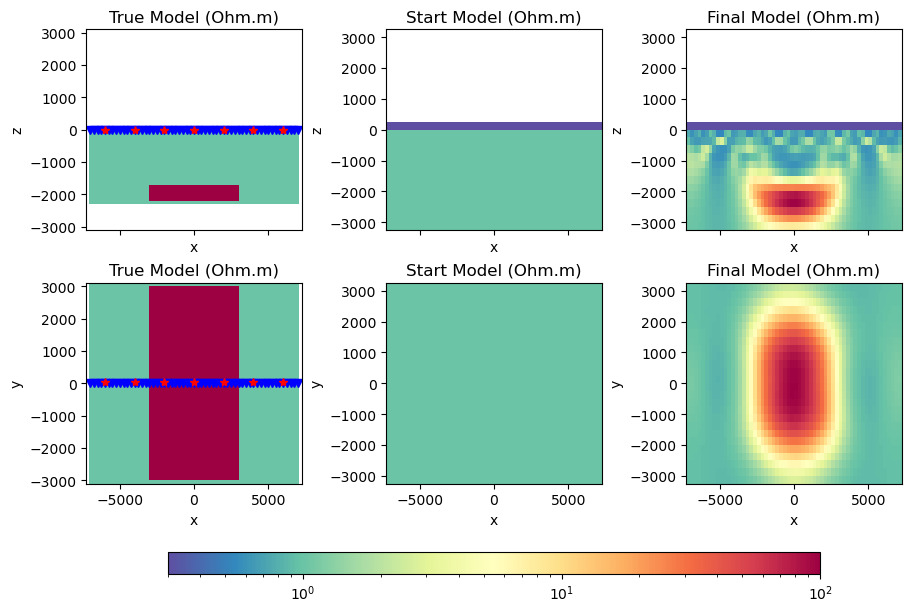

In [74]:
popts1 = {'cmap':'Spectral_r','norm':LogNorm(vmin=0.3, vmax=100)}
popts2 = {'edgecolors': 'grey', 'linewidth': 0.5, 'cmap':'Spectral_r','norm':LogNorm(vmin=0.3, vmax=100)}
opts = {'v_type': 'CC', 'normal': 'Y'}

rec_coords = sim.survey.receiver_coordinates()
src_coords = sim.survey.source_coordinates()

fig, axs = plt.subplots(2, 3, figsize=(9, 6), constrained_layout=True, sharex=True, sharey='col')
(ax1, ax2, ax3), (ax4, ax5, ax6) = axs

# True model
out1, = inp_grid.plot_slice(inp_data['true_model'].property_x.ravel('F'), ax=ax1, pcolor_opts=popts1, **opts)
ax1.set_title(f"True Model (Ohm.m)")
ax1.plot(rec_coords[0], rec_coords[1], 'bv')
ax1.plot(src_coords[0], src_coords[1], 'r*')

# Start model
out2, = model.grid.plot_slice(1/model.property_x.ravel('F'), ax=ax2, pcolor_opts=popts1, **opts)
ax2.set_title(f"Start Model (Ohm.m)")

# Final inversion model
out3, = model.grid.plot_slice(1/sim.model.property_x.ravel('F'), ax=ax3, pcolor_opts=popts1, **opts)
ax3.set_title(f"Final Model (Ohm.m)")

opts['normal'] = 'Z'
opts['ind'] = 4

# True model
out4, = inp_grid.plot_slice(inp_data['true_model'].property_x.ravel('F'), ax=ax4, pcolor_opts=popts1, **opts)
ax4.set_title(f"True Model (Ohm.m)")
ax4.plot(rec_coords[0], rec_coords[2], 'bv')
ax4.plot(src_coords[0], src_coords[2], 'r*')

# Start model
out5, = model.grid.plot_slice(1/model.property_x.ravel('F'), ax=ax5, pcolor_opts=popts1, **opts)
ax5.set_title(f"Start Model (Ohm.m)")

# Final inversion model
out6, = model.grid.plot_slice(1/sim.model.property_x.ravel('F'), ax=ax6, pcolor_opts=popts1, **opts)
ax6.set_title(f"Final Model (Ohm.m)")

plt.colorbar(out1, ax=axs, orientation='horizontal', fraction=.1, shrink=.8, aspect=30)
plt.savefig('ModelFit-7x7.png', dpi=300)

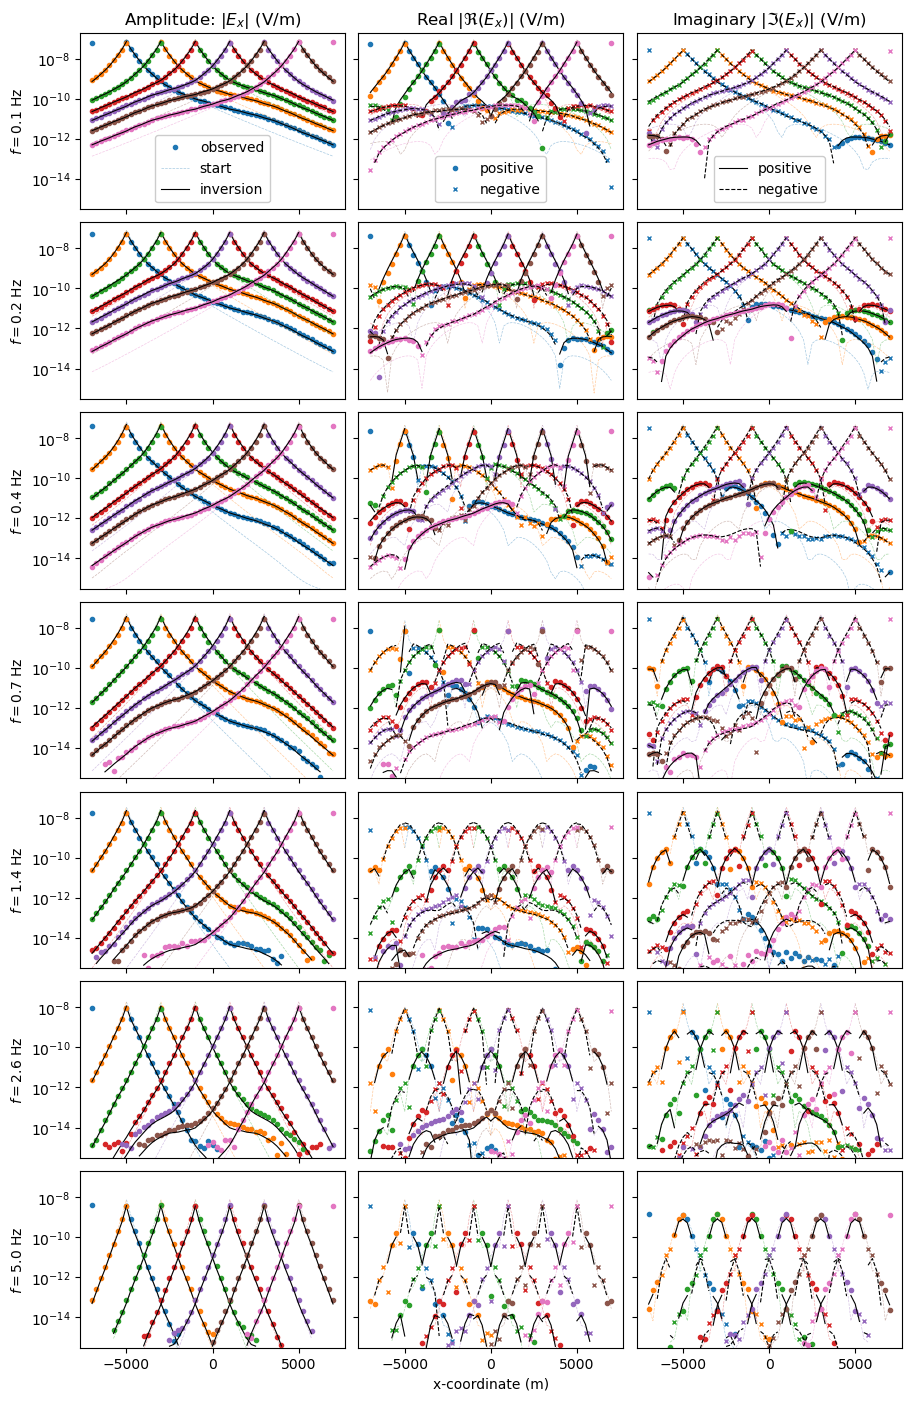

In [58]:
def pos(data):
    """Return positive data; set negative data to NaN."""
    return np.where(data > 0, data, np.nan)
    

height = sim.survey.shape[2]*1.7+2
fig, axs = plt.subplots(sim.survey.shape[2], 3, figsize=(9, height), constrained_layout=True, sharex=True, sharey=True)
axs = np.atleast_2d(axs)  # So it works if only 1 freq

# Data
obs = sim.data.observed
syn = sim.data.inv
syn.data[~np.isfinite(obs.data)] = np.nan+1j*np.nan
two = sim.data.synthetic
two.data[~np.isfinite(obs.data)] = np.nan+1j*np.nan

rec_coords = sim.survey.receiver_coordinates()

for ii, freq in enumerate(sim.survey.frequencies.keys()):
    for i, src in enumerate(sim.survey.sources.keys()):
        #if i in [1, 3, 5]:
        #    continue
        
        # Observed data
        axs[ii, 0].plot(rec_coords[0], abs(obs.loc[src, :, freq].data), f"C{i}.",
                        label='observed' if i == 0 else '')
        axs[ii, 1].plot(rec_coords[0], pos(obs.loc[src, :, freq].data.real), f"C{i}.",
                        label='positive' if i == 0 else '')
        axs[ii, 1].plot(rec_coords[0], pos(-obs.loc[src, :, freq].data.real), f"C{i}x", ms=3,
                        label='negative' if i == 0 else '')
        axs[ii, 2].plot(rec_coords[0], pos(obs.loc[src, :, freq].data.imag), f"C{i}.")
        axs[ii, 2].plot(rec_coords[0], pos(-obs.loc[src, :, freq].data.imag), f"C{i}x", ms=3)
        
        # Start model
        axs[ii, 0].plot(rec_coords[0], abs(two.loc[src, :, freq].data), f"C{i}--", alpha=.4, lw=0.5,
                        label='start' if i == 0 else '')
        axs[ii, 1].plot(rec_coords[0], abs(two.loc[src, :, freq].data.real), f"C{i}--", alpha=.4, lw=0.5)
        axs[ii, 2].plot(rec_coords[0], abs(two.loc[src, :, freq].data.imag), f"C{i}--", alpha=.4, lw=0.5)
        
        # Inverted data
        axs[ii, 0].plot(rec_coords[0], abs(syn.loc[src, :, freq].data), f"k-", lw=0.8,
                        label='inversion' if i == 0 else '')
        axs[ii, 1].plot(rec_coords[0], pos(syn.loc[src, :, freq].data.real), f"k-", lw=0.8)
        axs[ii, 1].plot(rec_coords[0], pos(-syn.loc[src, :, freq].data.real), f"k--", lw=0.8)
        axs[ii, 2].plot(rec_coords[0], pos(syn.loc[src, :, freq].data.imag), f"k-", lw=0.8,
                        label='positive' if i == 0 else '')
        axs[ii, 2].plot(rec_coords[0], pos(-syn.loc[src, :, freq].data.imag), f"k--", lw=0.8,
                        label='negative' if i == 0 else '')
        

    axs[ii, 0].set_ylabel(f'$f={sim.survey.frequencies[freq]}$ Hz')     

        
axs[0, 0].set_yscale('log')
axs[0, 0].set_ylim([3e-16, 2e-7])

axs[0, 0].set_title('Amplitude: $|E_x|$ (V/m)')
axs[0, 1].set_title('Real $|\Re(E_x)|$ (V/m)')
axs[0, 2].set_title('Imaginary $|\Im(E_x)|$ (V/m)')

axs[0, 0].legend(framealpha=1)
axs[0, 1].legend(framealpha=1)
axs[0, 2].legend(framealpha=1)

axs[-1, 1].set_xlabel('x-coordinate (m)')
plt.savefig('ResponseFit-7x7.png', dpi=300)
plt.show()

In [20]:
pg.Report('emg3d')

--------------------------------------------------------------------------------
  Date: Mon Dec 18 19:34:44 2023 CET

                OS : Linux
            CPU(s) : 256
           Machine : x86_64
      Architecture : 64bit
               RAM : 1007.1 GiB
       Environment : Jupyter
       File system : xfs

  Python 3.10.13 | packaged by conda-forge | (main, Oct 26 2023, 18:07:37)
  [GCC 12.3.0]

             emg3d : 1.8.2
           pygimli : 1.4.5
            pgcore : 1.4.0
             numpy : 1.24.4
        matplotlib : 3.8.2
             scipy : 1.11.4
              tqdm : 4.66.1
           IPython : 8.18.1
           pyvista : 0.43.1
--------------------------------------------------------------------------------

# Parking lot